# Desafio - Módulo 4

O objetivo desse exercício é classificar imagens pelo uso do Deep Learning (Keras e Tensorflow).

In [ ]:
#Libs nencessárias
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
#Versão do tf:
tf.__version__

'2.3.0'

In [ ]:
#Carregando o conjunto de dados
#import pathlib
#data_dir = tf.keras.utils.get_file(origin='http://download.tensorflow.org/example_images/flower_photos.tgz', fname='flower_photos', untar=True)

In [ ]:
#Carregando o conjunto de dados
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower', fname='flower_photos', untar=True)

data_dir = pathlib.Path(data_dir)

In [ ]:
#Total de imagens
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [ ]:
#Classes de imagens:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt'])
CLASS_NAMES

array(['roses', 'tulips', 'dandelion', 'daisy', 'sunflowers'],
      dtype='<U10')

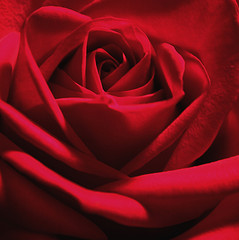

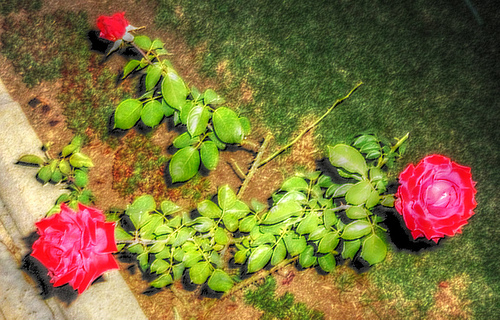

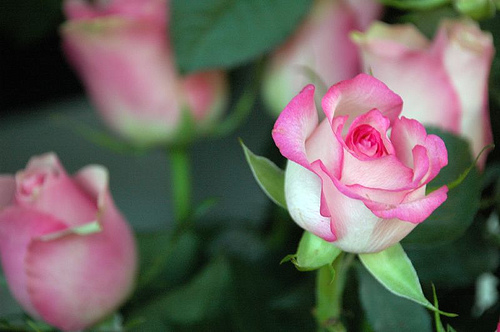

In [ ]:
#Listando roses
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
  display.display(Image.open(str(image_path)))

# Desafio

Exploração de dados

In [ ]:
module_selection = ("mobilenet_v2_100_224", 224) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


Modelagem

In [ ]:
do_fine_tuning = False 

In [ ]:
import tensorflow_hub as hub

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


Treinamento de modelo

In [ ]:
#Compilando o modelo
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
#Definindo epochs de treinamento, quantidade de vezes que as images serão treinadas
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
91/91 [==============================] - 16s 171ms/step - loss: 0.9258 - accuracy: 0.7551 - val_loss: 0.7290 - val_accuracy: 0.8438
Epoch 2/5
91/91 [==============================] - 15s 163ms/step - loss: 0.6878 - accuracy: 0.8782 - val_loss: 0.7338 - val_accuracy: 0.8438
Epoch 3/5
91/91 [==============================] - 15s 163ms/step - loss: 0.6546 - accuracy: 0.9002 - val_loss: 0.6806 - val_accuracy: 0.8821
Epoch 4/5
91/91 [==============================] - 15s 163ms/step - loss: 0.6215 - accuracy: 0.9192 - val_loss: 0.6782 - val_accuracy: 0.8821
Epoch 5/5
91/91 [==============================] - 15s 165ms/step - loss: 0.6099 - accuracy: 0.9233 - val_loss: 0.7105 - val_accuracy: 0.8665


Avaliação do modelo (acurácia)

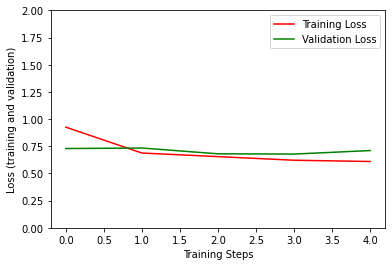

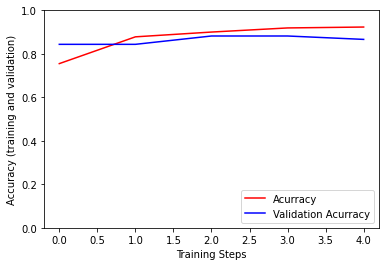

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"], color='red', label='Training Loss')
plt.plot(hist["val_loss"], color='green', label='Validation Loss')
plt.legend(loc='upper right')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"], color = 'red', label='Acurracy')
plt.plot(hist["val_accuracy"], color = 'blue', label='Validation Acurracy')
plt.legend(loc='lower right')

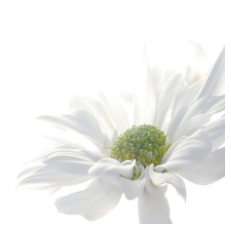

True label: daisy
Predicted label: daisy


In [ ]:
#Testando o modelo em 1 imagem do dataset
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [ ]:
#Salvando modelo
saved_model_path = "/tmp/saved_flowers_model"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


Predições

In [ ]:
#Prevendo novos dados de fora do treinamento e teste
from tensorflow import keras
batch_size = 32
img_height = 180
img_width = 180

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

ValueError: ignored

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

predictions = model.predict(test_images)

predictions[0]



In [ ]:
rever com https://www.tensorflow.org/hub/tutorials/image_feature_vector

Saiba mais em:

https://www.tensorflow.org/tutorials/images/classification?hl=pt

https://www.tensorflow.org/hub/tutorials/tf2_image_retraining?hl=pt

Visite mau [Github](https://github.com/k3ybladewielder) :3